## ISCX *Botnet* 2014 *Dataset*

Este *dataset* foi retirado da página da unb.ca (University of New Brunswick): https://www.unb.ca/cic/datasets/botnet.html

A informação que podemos obter é que se trata de uma junção de vários *datasets* sendo eles:
- ISOT Dataset
- ISCX 2012 IDS Dataset
- Botnet traffic generated by the Malware Capture Facility Project

### Informações do autor: 
O *dataset* de treino é composto por 43.92% de dados malignos e o *dataset* de teste é composto por 44.97% de dados malignos.

---

**No *dataset* de treino:**

Botnet name | Type | Portion of flows in dataset

    Neris                | IRC  | 21159  (12%)
    Rbot                 | IRC  | 39316  (22%)
    Virut                | HTTP | 1638   (0.94 %)
    NSIS                 | P2P  | 4336   (2.48%)
    SMTP Spam            | P2P  | 11296  (6.48%)
    Zeus                 | P2P  | 31     (0.01%)
    Zeus control (C & C) | P2P  | 20     (0.01%)

--- 

**No *dataset* de teste:**

Botnet name | Type | Portion of flows in dataset

    Neris              | IRC  | 25967 (5.67%)
    Rbot               | IRC  | 83    (0.018%)
    Menti              | IRC  | 2878  (0.62%)
    Sogou              | HTTP | 89    (0.019%)
    Murlo              | IRC  | 4881  (1.06%)
    Virut              | HTTP | 58576 (12.80%)
    NSIS               | P2P  | 757   (0.165%)
    Zeus               | P2P  | 502   (0.109%)
    SMTP Spam          | P2P  | 21633 (4.72%)
    UDP Storm          | P2P  | 44062 (9.63%)
    Tbot               | IRC  | 1296  (0.283%)
    Zero Access        | P2P  | 1011  (0.221%)
    Weasel             | P2P  | 42313 (9.25%)
    Smoke Bot          | P2P  | 78    (0.017%)
    Zeus Control (C&C) | P2P  | 31    (0.006%)
    ISCX IRC bot       | P2P  | 1816  (0.387%)

---

**IPs malignos:**

    IRC
        192.168.2.112 -> 131.202.243.84
        192.168.5.122 -> 198.164.30.2
        192.168.2.110 -> 192.168.5.122
        192.168.4.118 -> 192.168.5.122
        192.168.2.113 -> 192.168.5.122
        192.168.1.103 -> 192.168.5.122
        192.168.4.120 -> 192.168.5.122
        192.168.2.112 -> 192.168.2.110
        192.168.2.112 -> 192.168.4.120
        192.168.2.112 -> 192.168.1.103
        192.168.2.112 -> 192.168.2.113
        192.168.2.112 -> 192.168.4.118
        192.168.2.112 -> 192.168.2.109
        192.168.2.112 -> 192.168.2.105
        192.168.1.105 -> 192.168.5.122
        
    Neris: 147.32.84.180
    RBot: 147.32.84.170
    Menti: 147.32.84.150
    Sogou: 147.32.84.140
    Murlo: 147.32.84.130
    Virut: 147.32.84.160
    IRCbot and black hole1: 10.0.2.15
    Black hole 2: 192.168.106.141
    Black hole 3: 192.168.106.131
    TBot: 172.16.253.130, 172.16.253.131, 172.16.253.129, 172.16.253.240
    Weasel: Botmaster IP: 74.78.117.238; Bot IP: 158.65.110.24
    Zeus (zeus sample 1 and 2 and 3, bin_zeus): 192.168.3.35, 192.168.3.25, 192.168.3.65, 172.29.0.116
    Osx_trojan: 172.29.0.109
    Zero access (zero access 1 and 2): 172.16.253.132, 192.168.248.165
    Smoke bot: 10.37.130.4


### Importação de bibliotecas

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor 
# Nova adição para feature engineering 
from scipy.stats import boxcox
# Adição - métrica de avaliação de resultados Silhouette Score
from sklearn.metrics import silhouette_score

def safe_boxcox(series):
    arr = np.asarray(series.fillna(0.0).astype(float) + 1e-6)
    try:
        out, _ = boxcox(arr + 1e-6)
        return out
    except Exception:
        return np.log1p(arr)

def safe_sample(df, n, seed=42):
    if n >= len(df):
        return df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return df.sample(n=n, random_state=seed).reset_index(drop=True)

def ensure_numeric(df, cols):
    for c in cols:
        if c not in df.columns:
            df[c] = 0.0
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0.0)
    return df

### Leitura de datasets

In [3]:
# Carregar datasets
df_train = pd.read_csv(r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Testing_file.csv',
                       encoding='ISO-8859-1')

df_test = pd.read_csv(r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Training_file.csv',
                      encoding='ISO-8859-1')

### Exploração dos dados

In [4]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114514 entries, 0 to 5114513
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   No.          int64  
 1   Time         float64
 2   Source       object 
 3   Destination  object 
 4   Protocol     object 
 5   Length       int64  
 6   Info         object 
dtypes: float64(1), int64(2), object(4)
memory usage: 273.1+ MB


,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,NaN,NaN,Ethernet,60,[Packet size limited during capture]
1,2,6.985427,0.0.0.0,255.255.255.255,DHCP,348,DHCP Discover - Transaction ID 0x6145b920
2,3,6.985565,10.0.2.2,10.0.2.15,DHCP,590,DHCP Offer - Transaction ID 0x6145b920
3,4,6.985927,0.0.0.0,255.255.255.255,DHCP,373,DHCP Request - Transaction ID 0x6145b920
4,5,6.985998,10.0.2.2,10.0.2.15,DHCP,590,DHCP ACK - Transaction ID 0x6145b920


In [5]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388270 entries, 0 to 9388269
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   No.          int64  
 1   Time         float64
 2   Source       object 
 3   Destination  object 
 4   Protocol     object 
 5   Length       int64  
 6   Info         object 
dtypes: float64(1), int64(2), object(4)
memory usage: 501.4+ MB


,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,Cisco_db:19:c3,Broadcast,ARP,60,Who has 147.32.84.165? Tell 147.32.84.1
1,2,8.982709,Cisco_db:19:c3,Broadcast,ARP,60,Who has 147.32.84.165? Tell 147.32.84.1
2,3,50.099564,Cisco_db:19:c3,Broadcast,ARP,60,Who has 147.32.84.165? Tell 147.32.84.1
3,4,50.369266,54:52:00:00:00:01,Broadcast,ARP,60,Who has 147.32.84.165? Tell 147.32.84.85
4,5,51.369054,54:52:00:00:00:01,Broadcast,ARP,60,Who has 147.32.84.165? Tell 147.32.84.85


In [6]:
print("Valores nulos encontrados nos pacotes de Treino:\n",df_train.isnull().sum())  
print("Valores nulos encontrados nos pacotes de Teste:\n",df_test.isnull().sum())

Valores nulos encontrados nos pacotes de Treino:
 No.               0
Time              0
Source            1
Destination       1
Protocol          0
Length            0
Info           3898
dtype: int64
Valores nulos encontrados nos pacotes de Teste:
 No.                0
Time               0
Source             0
Destination        0
Protocol           0
Length             0
Info           49110
dtype: int64


In [7]:
print(df_train['Time'].describe())  
print("Valores de Tempo negativo nos pacotes de Treino: ", (df_train['Time'] < 0).sum())

count    5.114514e+06
mean     1.284569e+09
std      4.879074e+07
min      0.000000e+00
25%      1.276250e+09
50%      1.276579e+09
75%      1.313450e+09
max      1.359942e+09
Name: Time, dtype: float64
Valores de Tempo negativo nos pacotes de Treino:  0


In [8]:
print(df_test['Time'].describe())  
print("Valores de Tempo negativo nos pacotes de Teste: ", (df_test['Time'] < 0).sum())

count    9.388270e+06
mean    -4.999973e+07
std      3.936417e+07
min     -1.211172e+08
25%     -3.664793e+07
50%     -3.662771e+07
75%     -3.659487e+07
max      7.802317e+05
Name: Time, dtype: float64
Valores de Tempo negativo nos pacotes de Teste:  8171941


In [9]:
print("Protocolos encontrados no conjunto de Treino:")
print(df_train["Protocol"].unique())
# ________________________________ #
print("\nProtocolos encontrados no conjunto de Teste:")
print(df_test["Protocol"].unique())

Protocolos encontrados no conjunto de Treino:
['Ethernet' 'DHCP' 'ARP' 'SSDP' 'ICMP' 'IGMPv3' 'NBNS' 'BROWSER' 'DNS'
 'TCP' 'HTTP' 'NBSS' 'SMB' 'LANMAN' 'DCERPC' 'SRVSVC' 'WKSSVC' 'SPOOLSS'
 'SMB Pipe' 'UDP' 'SSLv2' 'IRC' 'TLSv1' 'SNMP' 'SMTP' 'SMTP/IMF' 'SSLv3'
 'NTP' 'HTTP/JSON' 'IPv4' 'SSH' 'PKIX-CRL' 'RDP' 'COTP' 'T.125' 'HTTP/XML'
 'CLASSIC-STUN' 'IOXIDResolver' 'ISystemActivator' 'X11' 'RTCP' 'SSL'
 'SIP' 'DB-LSP-DISC/JSON' 'ICMPv6' 'LLMNR' 'UDP/XML' 'DHCPv6' 'STP'
 'RIPv2' '0x0000' 'DB-LSP-DISC' '0x0700' 'LLDP' 'IPX SAP' 'NBDS' 'SRVLOC'
 'BOOTP' '0xffff' 'MDNS' 'IGMPv1' '0x4b0d' '0x4000' 'LLC' '0xe000' 'SSHv2'
 '0x3339' 'IGMPv2' 'IPv6' 'DTLS' 'eDonkey' 'ALLJOYN-NS'
 'openSAFETY over UDP' '0x2aa1' 'ECMP' 'TCP, HiPerConTracer' 'H1'
 'BitTorrent' 'SIGCOMP' 'MSMMS' 'TRDP' 'QUAKEWORLD' 'ECHO' 'H.225.0'
 'GPRS-NS' '5co-legacy' 'UDP, HiPerConTracer' 'WSP' 'QUAKE3' '0xc8d8'
 'VxLAN' '0xb0c8' '0x9cb1' '0x33a5' 'MSNMS' 'FIND' 'CIP I/O' 'POP'
 'POP/IMF' 'BT-DHT' 'LSD' 'WireGuard' 'FTP' 'FT

In [10]:
# Valores estatísticos do tamanho dos pacotes
print("Medidas estatísticas do tamanho de pacotes de Treino:")
print(df_train['Length'].describe())  # Min, max, mean, etc.

print("============================")

print("Medidas estatísticas do tamanho de pacotes de Teste:")
print(df_test['Length'].describe())  # Min, max, mean, etc.

Medidas estatísticas do tamanho de pacotes de Treino:
count    5.114514e+06
mean     4.545508e+02
std      1.057905e+03
min      4.200000e+01
25%      6.000000e+01
50%      6.700000e+01
75%      6.240000e+02
max      6.523800e+04
Name: Length, dtype: float64
Medidas estatísticas do tamanho de pacotes de Teste:
count    9.388270e+06
mean     5.448353e+02
std      6.522112e+02
min      5.400000e+01
25%      6.000000e+01
50%      9.600000e+01
75%      1.434000e+03
max      1.903400e+04
Name: Length, dtype: float64


### Pré-Processamento

In [11]:
# Preencher valores NaN com "Unknown" em Info e remover valores NaN em Source e Destination
df_train.fillna({"Info": "Unknown"}, inplace=True)
df_test.fillna({"Info": "Unknown"}, inplace=True)
df_train.dropna(subset=['Source', 'Destination'], inplace=True)
df_test.dropna(subset=['Source', 'Destination'], inplace=True)

In [12]:
# Converter features categóricas (strings e objetos) em atributos numéricos 
df_train['Protocol'] = df_train['Protocol'].astype('category').cat.codes
df_train['Source'] = df_train['Source'].astype('category').cat.codes
df_train['Destination'] = df_train['Destination'].astype('category').cat.codes

df_test['Protocol'] = df_test['Protocol'].astype('category').cat.codes
df_test['Source'] = df_test['Source'].astype('category').cat.codes
df_test['Destination'] = df_test['Destination'].astype('category').cat.codes

### Engenharia de *Atributos*

LOG - Iterações feitas durante o desenvolvimento: 

    . Time_Diff é computada por IP Origem em vez de globalmente 

    . versão anterior de Packet_Rate usava ".count() / (x.max() - x.min())" que pode
    ser sensível a outliers. Nova versão usa IQR para excluir outliers extremos.

    . Inter-Arrival Time passa a usar média móvel em vez de estática (Melhor eficiência)

    . Usar "np.where" em Burst_Rate para salvaguardar em caso de Inter-Arrival Time = 0.

    . Features com transformada logarítmica desaparecem e usa-se BoxCox - melhor para dados com distorção.

    . Usar trasformada logarítimica em Inter-Arrival e Burst_Rate para melhorar para reduzir
    o nível de distorção dos dados e manter a distribuição dos dados estável (teste).

In [17]:
def build_features(df):
    df = df.copy()
    src = 'Source_enc' if 'Source_enc' in df.columns else 'Source'
    dst = 'Destination_enc' if 'Destination_enc' in df.columns else 'Destination'
    if 'Time' in df.columns:
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce').fillna(0.0)
        df['Time_Diff'] = df.groupby(src)['Time'].diff().fillna(df.groupby(src)['Time'].transform('median')).fillna(0.0)
    else:
        df['Time_Diff'] = 0.0
    def pkt_rate_series(s):
        a = s.dropna().values
        if a.size < 2:
            return pd.Series(np.zeros(len(s)), index=s.index)
        q1, q3 = np.percentile(a, [25,75])
        iqr = max(q3 - q1, 1e-9)
        cl = np.clip(a, q1 - 1.5*iqr, q3 + 1.5*iqr)
        denom = cl.max() - cl.min()
        if denom <= 1e-6:
            rate = np.zeros_like(a)
        else:
            rate = np.full_like(a, cl.size / denom, dtype=float)
        out = pd.Series(rate, index=s.dropna().index)
        return out.reindex(s.index).fillna(0.0)
    if 'Time' in df.columns:
        df['Packet_Rate'] = df.groupby(src)['Time'].transform(lambda s: pkt_rate_series(s)).fillna(0.0)
    else:
        df['Packet_Rate'] = 0.0
    df['Inter_Arrival_Time'] = df.groupby(src)['Time_Diff'].transform(lambda s: s.rolling(10, min_periods=1).mean()).fillna(0.0).clip(lower=1e-6)
    df['Burst_Rate'] = np.where(df['Inter_Arrival_Time']>1e-6, 1.0/df['Inter_Arrival_Time'], 0.0)
    df['Length'] = pd.to_numeric(df.get('Length', 0)).fillna(0)
    df['Length_Mean'] = df.groupby(src)['Length'].transform('mean').fillna(df['Length'].mean() if 'Length' in df.columns else 0.0)
    df['Length_Std']  = df.groupby(src)['Length'].transform('std').fillna(0.0)
    df['Pkt_Per_Src'] = df.groupby(src)['Length'].transform('count').fillna(0).astype(int)
    if 'Time' in df.columns:
        df['Session_Dur_Src'] = df.groupby(src)['Time'].transform(lambda x: x.max() - x.min()).fillna(0.0)
        df['Session_Dur_Dst'] = df.groupby(dst)['Time'].transform(lambda x: x.max() - x.min()).fillna(0.0)
    else:
        df['Session_Dur_Src'] = 0.0
        df['Session_Dur_Dst'] = 0.0
    df['Bytes_Per_Session_Src'] = df.groupby(src)['Length'].transform('sum').fillna(0.0)
    df['Bytes_Per_Session_Dst'] = df.groupby(dst)['Length'].transform('sum').fillna(0.0)
    df['Packets_Per_Session_Src'] = df['Pkt_Per_Src']
    df['Packets_Per_Session_Dst'] = df.groupby(dst)['Length'].transform('count').fillna(0).astype(int)
    df['Log_IATime'] = np.log1p(df['Inter_Arrival_Time'])
    df['Log_BRate']  = np.log1p(df['Burst_Rate'].clip(lower=0))
    df['BoxCox_Length'] = safe_boxcox(df['Length']) if 'Length' in df.columns else np.zeros(len(df))
    df['BoxCox_PRate']  = safe_boxcox(df['Packet_Rate'])
    df['Rate_to_Length'] = df['Burst_Rate'] / (df['BoxCox_Length'] + 1e-6)
    df['IAT_to_Session'] = df['Inter_Arrival_Time'] / (df['Session_Dur_Src'] + 1e-6)
    df['Burst_Variability'] = df['Burst_Rate'].rolling(5, min_periods=1).std().fillna(0.0).values
    df['Pkt_Rate_Change']  = df['Packet_Rate'].diff().fillna(0.0).values
    
    features = ['Time_Diff','Log_IATime','Log_BRate',
                'BoxCox_Length','BoxCox_PRate','Length_Mean',
                'Length_Std','Pkt_Per_Src','Session_Dur_Src',
                'Session_Dur_Dst','Rate_to_Length','IAT_to_Session',
                'Burst_Variability','Pkt_Rate_Change',
                'Bytes_Per_Session_Src','Packets_Per_Session_Src']
    
    df = ensure_numeric(df, features)
    return df, features

df_train, features_train = build_features(df_train)
df_test, features_test   = build_features(df_test)

NUM_FEATURES = list(dict.fromkeys(features_train + features_test))

df_train_sample = safe_sample(df_train, 300_000)
df_test_sample  = safe_sample(df_test, 300_000)

In [18]:
# Escalonamento
features = ["Pkt_Per_Src","Burst_Rate","Session_Dur_Src",
            "Inter_Arrival_Time","BoxCox_Length","Rate_to_Length",
            "IAT_to_Session","Burst_Variability","Pkt_Rate_Change",
            "Bytes_Per_Session_Src","Packets_Per_Session_Src"]

scaler = MinMaxScaler()
scaler.fit(df_train[features])
df_train_scaled = pd.DataFrame(scaler.transform(df_train[features]), columns=features)
df_test_scaled = pd.DataFrame(scaler.transform(df_test[features]), columns=features)

In [19]:
# manipular valores duplicados (problemas anteriores com duplicação de valores)

df_train_scaled = df_train_scaled.drop_duplicates()
df_test_scaled = df_test_scaled.drop_duplicates()

# adicionar ruído para tratar valores muito idênticos 
df_train_scaled += np.random.normal(0, 1e-6, df_train_scaled.shape)
df_test_scaled += np.random.normal(0, 1e-6, df_test_scaled.shape)

# reduzir precisão (motivos de recursos computacionais)
df_train_scaled = df_train_scaled.astype("float32")
df_test_scaled = df_test_scaled.astype("float32")

### Treinar primeiro modelo (*Isolation Forest*)

In [20]:
# Isolation Forest (IForest)
iso_forest = IsolationForest(
    n_estimators=550,
    contamination="auto",
    random_state=45,
    verbose=0) 

iso_forest.fit(df_train_scaled)
df_train_scaled["Anomaly_IForest"] = iso_forest.predict(df_train_scaled)
df_test_scaled["Anomaly_IForest"] = iso_forest.predict(df_test_scaled)

print(f"Anomalias encontradas na fase de Treino: {(df_train_scaled['Anomaly_IForest'] == -1).sum() / len(df_train_scaled) * 100:.2f}%")
print(f"Anomalias encontradas na fase de Teste: {(df_test_scaled['Anomaly_IForest'] == -1).sum() / len(df_test_scaled) * 100:.2f}%")

Anomalias encontradas na fase de Treino: 11.11%
Anomalias encontradas na fase de Teste: 18.25%


### Treinar segundo modelo (OCSVM, AutoEncoder, -> LOF)

CONSIDERAÇÕES:

n_neighbors:
quanto maior o valor da vizinhança, maior o consumo de memória. 
Este consumo pode crescer rapidamente, ainda mais com o uso de muitos dados,
então usamos apenas uma amostra dos dados, para treinar o algoritmo e não 
usar tanto poder computacional.
    
    -> usar valores altos se anomalias forem dispersas globalmente, e valores baixos se anomalias forem densas localmente
    -> experimentar: 30, 50 (default), 100, *150*

metrics: 

    euclidean- default, 
    
    chebyshev - network logs, 
    
    manhattan - packet-based data

* Aumenta 10% por cada vez que aumenta 'contamination':
  
    -> 0.1 - 10%, 0.2 - 20%, 0.3 - 30% ...
  
  Usei "auto" para não forçar anomalias.

  * melhor métrica: 

In [21]:
# Local Outlier Factor (LOF)
batch_size = 200_000

lof = LocalOutlierFactor(
    n_neighbors=30,
    algorithm="ball_tree", # a usar: "ball_tree" ou "kd_tree". Algoritmos de pesquisa k-NN
    leaf_size=100, # valores mais baixos são mais preciso, mas demoram mais tempo para terminar
    contamination="auto", 
    metric="manhattan",
    #novelty=False,
    n_jobs=-1)

def lof_predict(data, batch_size, lof_model):
    
    y_pred = np.zeros(len(data))
    
    for i in range(0, len(data), batch_size):
        batch = data.iloc[i:i + batch_size]  
        y_pred[i:i + batch_size] = lof_model.fit_predict(batch) 

    return y_pred

df_train_scaled['Anomaly_LOF'] = lof_predict(df_train_scaled, batch_size, lof)
df_test_scaled['Anomaly_LOF'] = lof_predict(df_test_scaled, batch_size, lof)

print(f"Anomalias encontradas na fase de Treino: {(df_train_scaled['Anomaly_LOF'] == -1).sum() / len(df_train_scaled) * 100:.2f}%")
print(f"Anomalias encontradas na fase de Teste: {(df_test_scaled['Anomaly_LOF'] == -1).sum() / len(df_test_scaled) * 100:.2f}%")

KeyboardInterrupt: 

In [ ]:
# Nível de concordância entre os modelos

overlap = (df_train_scaled["Anomaly_LOF"] == df_train_scaled["Anomaly_IForest"]).mean()
print(f"Concordância entre algoritmos: LOF/I-Forest: {overlap:.2%}")

### Visualização gráfica dos resultados.

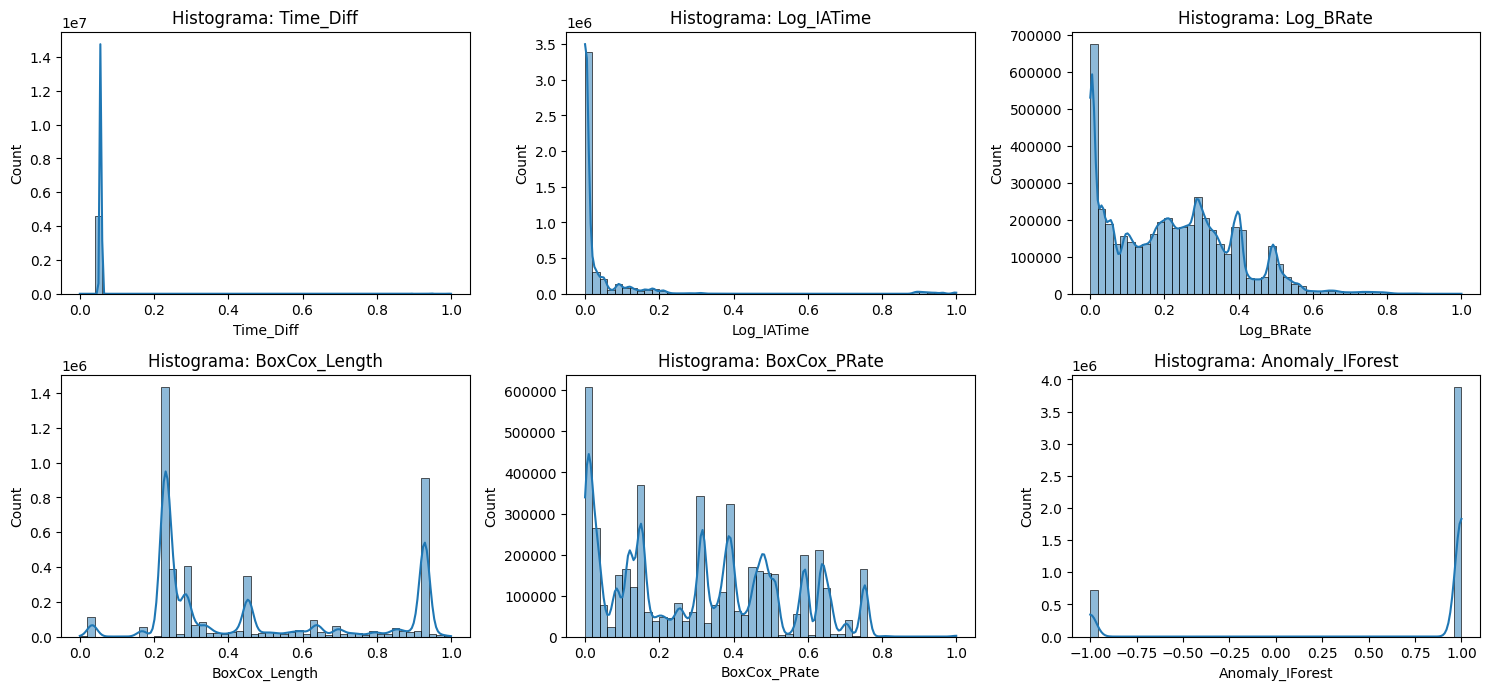

In [18]:
# Histograma de distribuição de features,ç
features = df_train_scaled.columns[:-1]  # Exclui rótulos de anomalias
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_train_scaled[feature], bins=50, kde=True)
    plt.title(f"Histograma: {feature}")
plt.tight_layout()
plt.show()

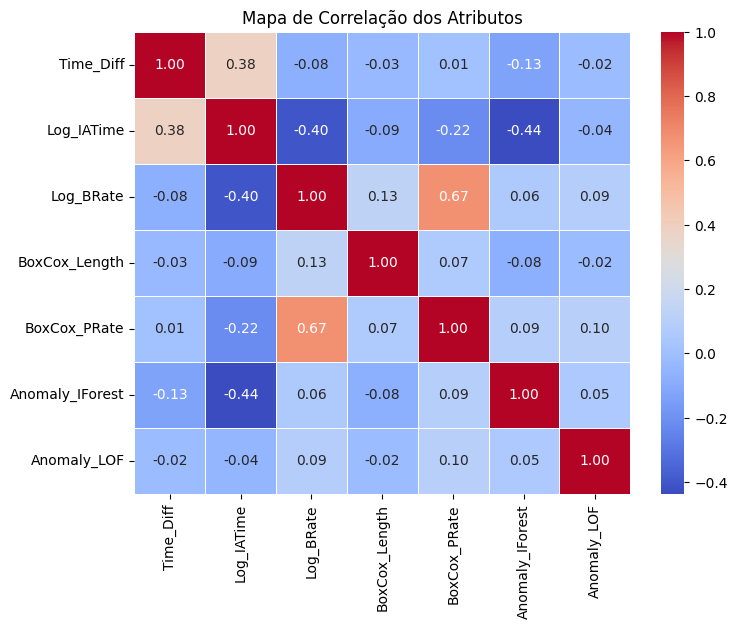

In [19]:
# Mapa de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(df_train_scaled.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Mapa de Correlação dos Atributos")
plt.show()

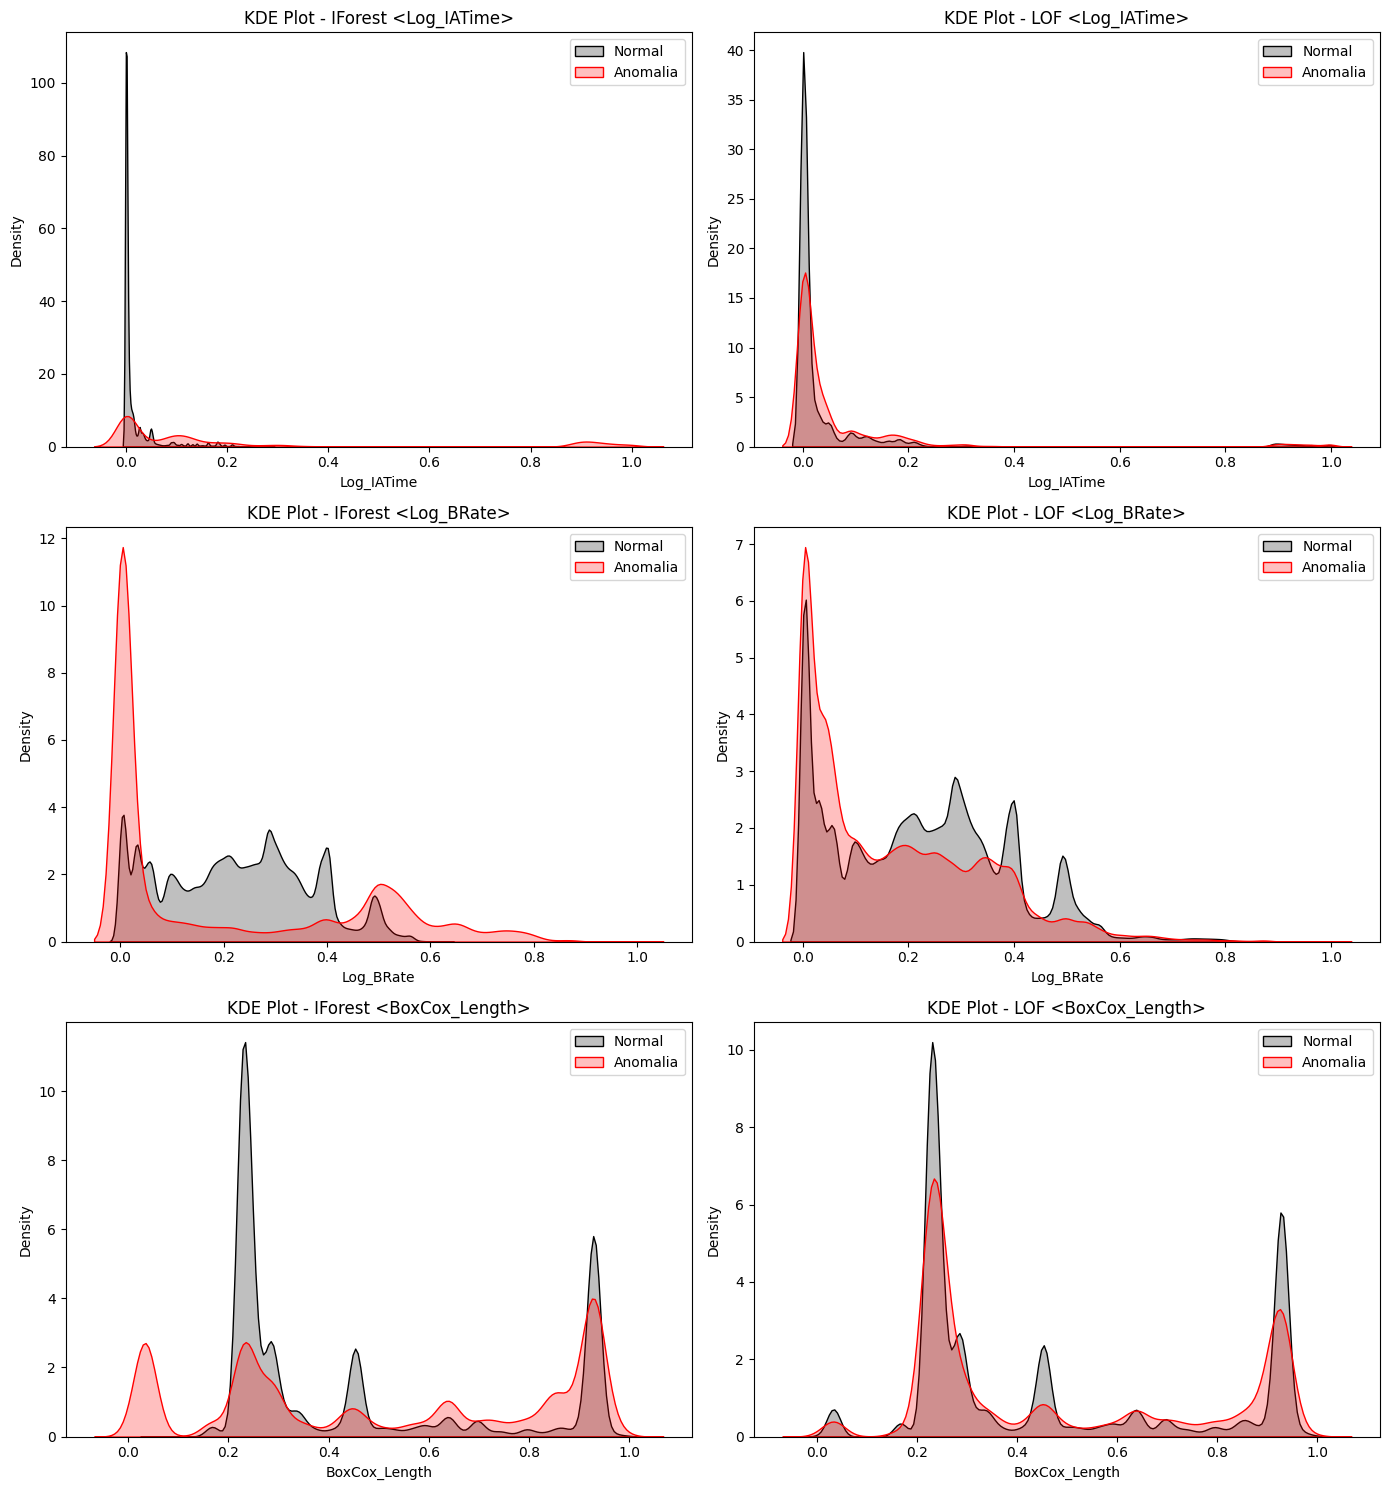

In [20]:
# Como há atributos muito semelhantes como visto no mapa de correlação
# escolheu-se apenas aqueles que se apresentam distintos entre si. 

selected_features = ["Log_IATime", "Log_BRate", "BoxCox_Length"]

fig, axes = plt.subplots(len(selected_features), 2, figsize=(14, 5 * len(selected_features)))

for i, feature in enumerate(selected_features):
    # Isolation Forest KDE
    sns.kdeplot(df_train_scaled[df_train_scaled["Anomaly_IForest"] == 1][feature], 
                label="Normal", color="black", ax=axes[i, 0], fill=True)
    sns.kdeplot(df_train_scaled[df_train_scaled["Anomaly_IForest"] == -1][feature], 
                label="Anomalia", color="red", ax=axes[i, 0], fill=True)
    axes[i, 0].set_title(f"KDE Plot - IForest <{feature}>")
    axes[i, 0].legend()
    
    # Local Outlier Factor KDE
    sns.kdeplot(df_train_scaled[df_train_scaled["Anomaly_LOF"] == 1][feature], 
                label="Normal", color="black", ax=axes[i, 1], fill=True)
    sns.kdeplot(df_train_scaled[df_train_scaled["Anomaly_LOF"] == -1][feature], 
                label="Anomalia", color="red", ax=axes[i, 1], fill=True)
    axes[i, 1].set_title(f"KDE Plot - LOF <{feature}>")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### Métrica de avaliação de resultados

#### Silhouette Score
 * **Como funciona:**
   
    -> Para cada ponto no dataset
   
   calcula a distância ao seu cluster (coesão).
   
   calcula a distância aos outros clusters (distinção)

    -> Funciona no intervalo de -1 a 1

   -1 é péssima distinção.
   
   0 é porque existe sobreposição de valores.
   
   1 é perfeita distinção.

In [21]:
sample = 40_000
num_batches = len(df_train_scaled) // sample  # Número de partições

# Listas
sil_scores_if_train = []
sil_scores_if_test = []
sil_scores_lof_train = []
sil_scores_lof_test = []

for i in range(num_batches):
    print(f"A processar partição {i+1}/{num_batches}...")

    train_batch = df_train_scaled.iloc[i * sample : (i + 1) * sample]
    test_batch = df_test_scaled.iloc[i * sample : (i + 1) * sample]

    sil_scores_if_train.append(silhouette_score(train_batch, train_batch["Anomaly_IForest"], metric="manhattan"))
    sil_scores_if_test.append(silhouette_score(test_batch, test_batch["Anomaly_IForest"], metric="manhattan"))

    sil_scores_lof_train.append(silhouette_score(train_batch, train_batch["Anomaly_LOF"], metric="manhattan"))
    sil_scores_lof_test.append(silhouette_score(test_batch, test_batch["Anomaly_LOF"], metric="manhattan"))

# Médias
avg_sil_if_train = np.mean(sil_scores_if_train)
avg_sil_if_test = np.mean(sil_scores_if_test)
avg_sil_lof_train = np.mean(sil_scores_lof_train)
avg_sil_lof_test = np.mean(sil_scores_lof_test)

print(f"\nAvaliação final:")
print(f"I-Forest -> Train: {avg_sil_if_train:.4f}")
print(f"I-Forest -> Test: {avg_sil_if_test:.4f}")
print(f"LOF -> Train: {avg_sil_lof_train:.4f}")
print(f"LOF -> Test: {avg_sil_lof_test:.4f}")

A processar partição 1/115...
A processar partição 2/115...
A processar partição 3/115...
A processar partição 4/115...
A processar partição 5/115...
A processar partição 6/115...
A processar partição 7/115...
A processar partição 8/115...
A processar partição 9/115...
A processar partição 10/115...
A processar partição 11/115...
A processar partição 12/115...
A processar partição 13/115...
A processar partição 14/115...
A processar partição 15/115...
A processar partição 16/115...
A processar partição 17/115...
A processar partição 18/115...
A processar partição 19/115...
A processar partição 20/115...
A processar partição 21/115...
A processar partição 22/115...
A processar partição 23/115...
A processar partição 24/115...
A processar partição 25/115...
A processar partição 26/115...
A processar partição 27/115...
A processar partição 28/115...
A processar partição 29/115...
A processar partição 30/115...
A processar partição 31/115...
A processar partição 32/115...
A processar parti